In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models import BiRNN
from ANFISpy import RANFIS

## Pre-Processing

Importing and converting data.

In [2]:
df = pd.read_csv('brazil_covid19_macro.csv')
cases = df['cases'].values
dates = df['date'].values
days = np.array([i for i in range(cases.shape[0])], dtype='float32')

tick_indices = [i for i, d in enumerate(dates) if d.endswith('-01')]
tick_labels = [dates[i] for i in tick_indices]

Processing the data.

In [3]:
total_len = len(cases)  
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

cases_train = cases[:train_size + val_size]
cases_test = cases[train_size + val_size:]

days_train = days[:train_size + val_size]
days_test = days[train_size + val_size:]

norm_min, norm_max = cases_train.min(), cases_train.max()

cases_train = (cases_train - norm_min) / (norm_max - norm_min)
cases_test  = (cases_test - norm_min) / (norm_max - norm_min)

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])     
        y.append(data[i + 1 : i + seq_length + 1])  
    x = torch.FloatTensor(np.array(x)).unsqueeze(-1) 
    y = torch.FloatTensor(np.array(y)).unsqueeze(-1)
    return x, y

seq_len_birnn = 11

x_train, y_train = create_sequences(cases_train, seq_len_birnn)
x_test,  y_test  = create_sequences(cases_test, seq_len_birnn)

aligned_days_train = days_train[seq_len_birnn:]
aligned_days_test  = days_test[seq_len_birnn:]

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

Instantiating RNN.

In [4]:
birnn = BiRNN(
    h=118,
    activation=nn.Identity(),
)

params_birnn = 0
for p in list(birnn.parameters()):
    params_birnn += p.flatten().shape[0]
    
print(f'Number of parameters: {params_birnn}')

Number of parameters: 28675


Training the model.

In [5]:
try:
    best_model_path = 'best_models/birnn.pth'  
    checkpoint = torch.load(best_model_path, weights_only=True)
    birnn.load_state_dict(checkpoint['model_state_dict'])
    print('Loaded.')

except:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(birnn.parameters(), lr=0.000263)

    epochs = 100
    best_train_loss = float('inf')
    best_model_path = 'best_models/birnn.pth'

    for epoch in range(epochs):
        birnn.train()
        epoch_loss_train = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = birnn(X_batch)[0]
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item() * X_batch.size(0) 

        epoch_loss_train /= len(train_loader.dataset)

        if epoch_loss_train < best_train_loss:
                best_train_loss = epoch_loss_train
                torch.save({
                    'model_state_dict': birnn.state_dict(),
                }, best_model_path)

        if epoch % 50 == 0:
            print(f'Epoch {epoch} | Train Loss: {best_train_loss:.8f}')

    checkpoint = torch.load(best_model_path, weights_only=True)
    birnn.load_state_dict(checkpoint['model_state_dict'])

Loaded.


Plotting training data predictions.

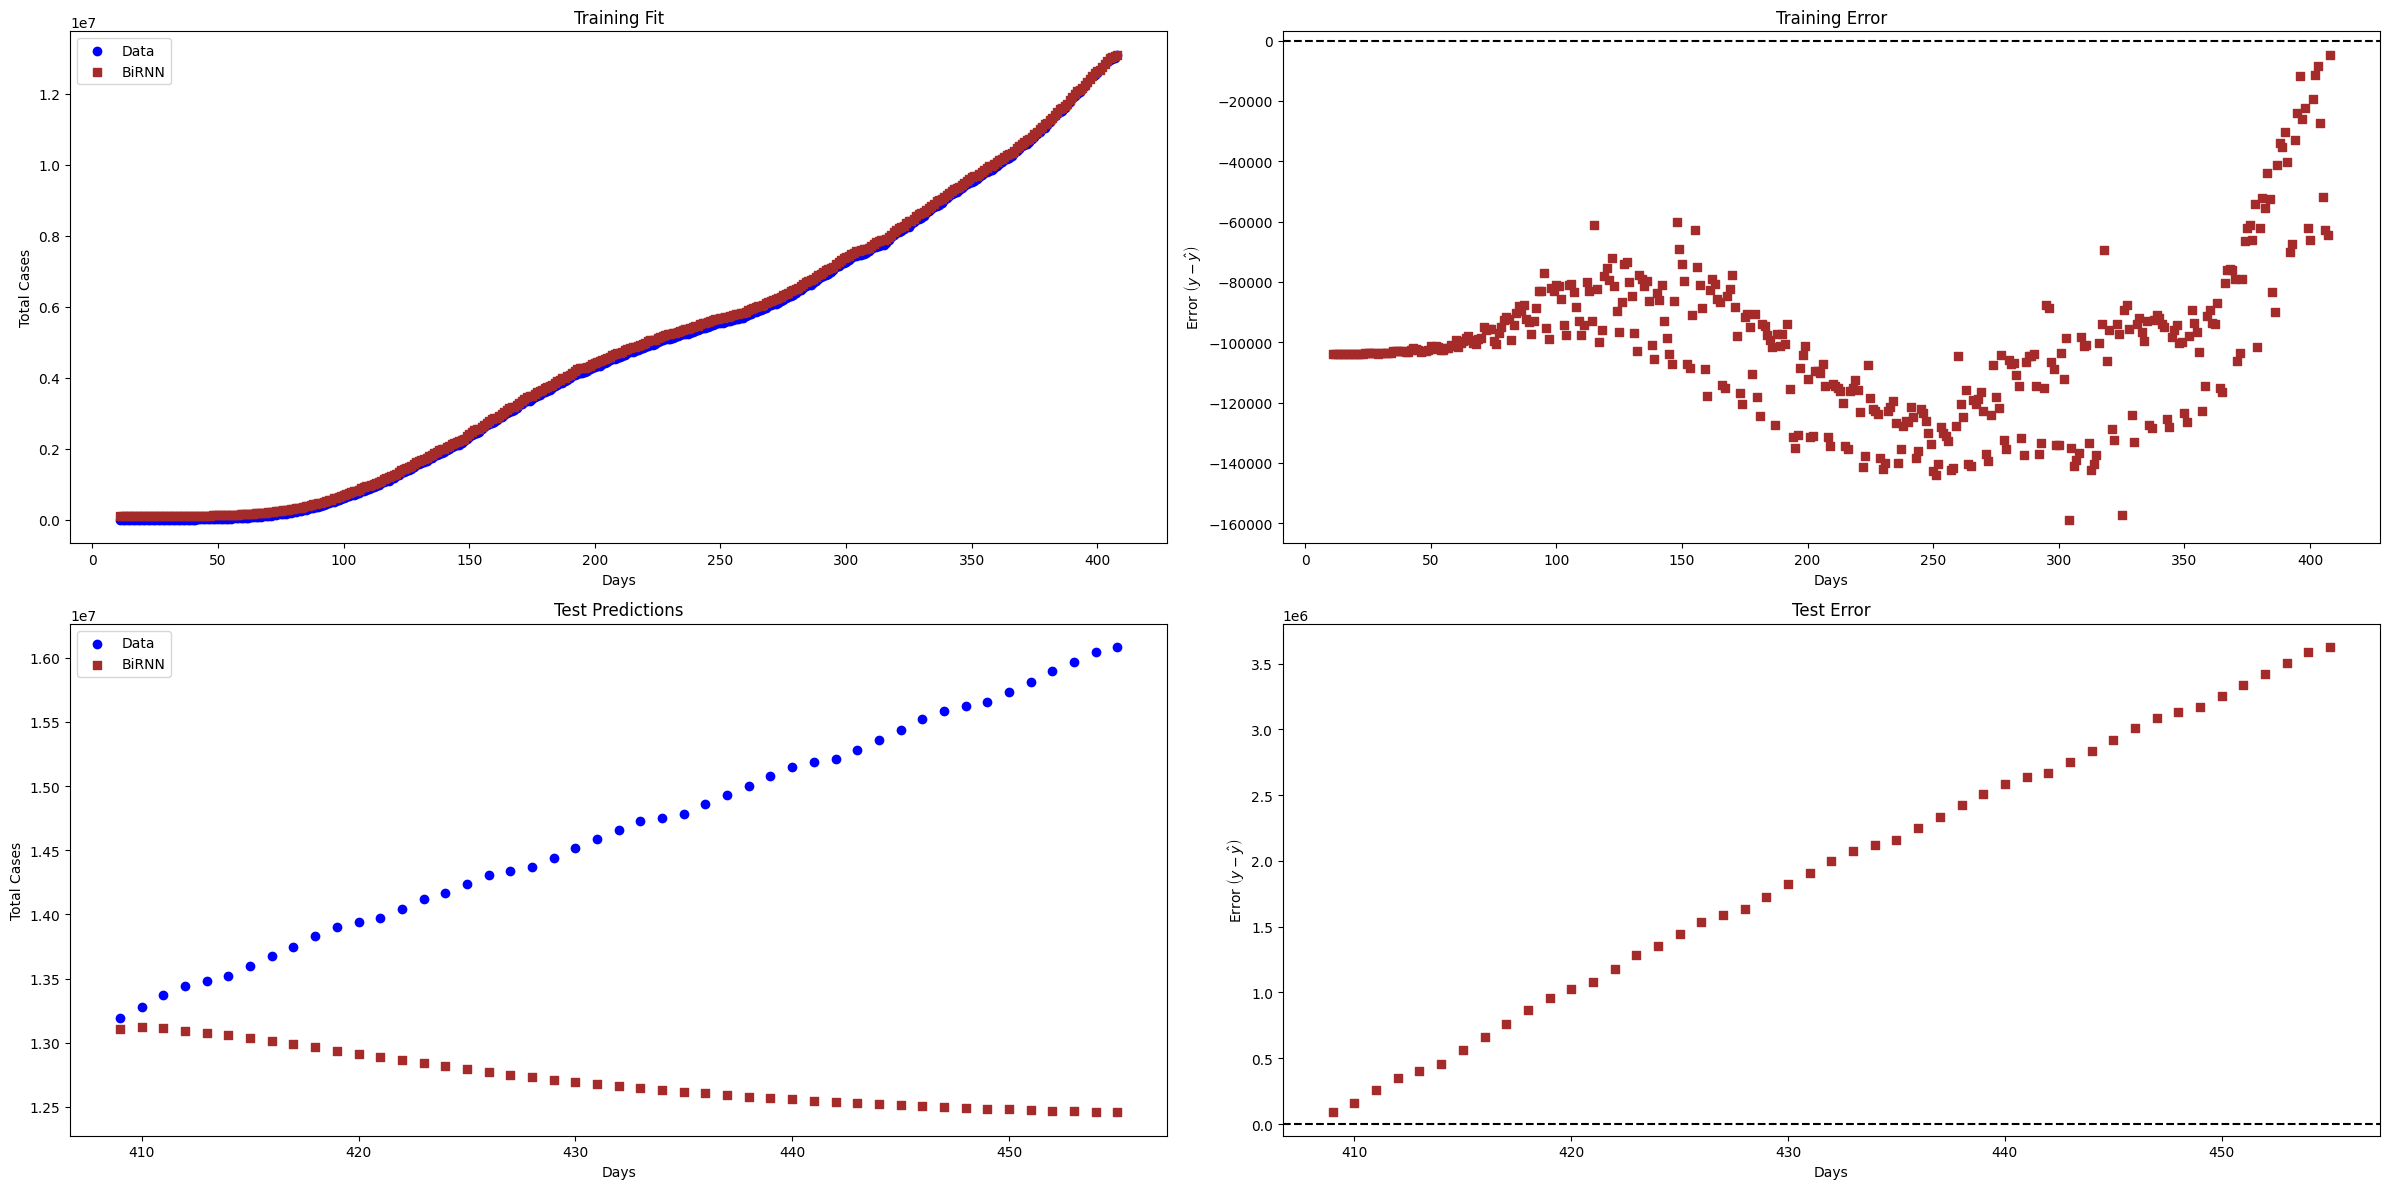

In [6]:
birnn.eval()
test_predictions_birnn = []

with torch.no_grad():
    train_predictions_birnn = birnn(x_train)[0][:, -1, :].numpy().flatten()
    
    last_data = x_train[-1:]
    h = None
    
    for _ in range(len(days_test)):  
        pred, hnew = birnn(last_data, h)  
        test_predictions_birnn.append(pred[:, -1:, 0].item())
        last_data = torch.cat([last_data[:, 1:, :], pred[:, -1:, :]], dim=1)  
        h = hnew
        
train_predictions_birnn = train_predictions_birnn * (norm_max - norm_min) + norm_min
test_predictions_birnn = np.array(test_predictions_birnn) * (norm_max - norm_min) + norm_min

cases_train_denorm = cases_train[seq_len_birnn:] * (norm_max - norm_min) + norm_min
cases_test_denorm = cases_test * (norm_max - norm_min) + norm_min

fig, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0, 0].scatter(aligned_days_train, cases_train_denorm, label='Data', c='blue')
ax[0, 0].scatter(aligned_days_train, train_predictions_birnn, label='BiRNN', marker='s', c='brown')
ax[0, 0].set_title("Training Fit")
ax[0, 0].set_xlabel("Days")
ax[0, 0].set_ylabel("Total Cases")
ax[0, 0].legend()

ax[0, 1].scatter(aligned_days_train, cases_train_denorm - train_predictions_birnn, color='brown', marker='s')
ax[0, 1].axhline(0, color='black', linestyle='--')
ax[0, 1].set_title("Training Error")
ax[0, 1].set_xlabel("Days")
ax[0, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

ax[1, 0].scatter(days_test, cases_test_denorm, label='Data', c='blue')
ax[1, 0].scatter(days_test, test_predictions_birnn, label='BiRNN', marker='s', c='brown')
ax[1, 0].set_title("Test Predictions")
ax[1, 0].set_xlabel("Days")
ax[1, 0].set_ylabel("Total Cases")
ax[1, 0].legend()

ax[1, 1].scatter(days_test, cases_test_denorm - test_predictions_birnn, color='brown', marker='s')
ax[1, 1].axhline(0, color='black', linestyle='--')
ax[1, 1].set_title("Test Error")
ax[1, 1].set_xlabel("Days")
ax[1, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

plt.tight_layout()
plt.show()

## BiRANFIS

Instantiating model.

In [7]:
n_vars = 1
seq_len_biranfis = 5
mf_names = [['EL', 'VL', 'L', 'ML', 'M', 'MH', 'H', 'VH', 'EH']]

variables = {
    'inputs': {
        'n_sets': [9],
        'uod': n_vars * [(0, 1.5)],
        'var_names': ['Cases'],
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': 'New Cases',
        'n_classes': 1,
    },
}

biranfis = RANFIS(
    variables, 
    'bell', 
    seq_len_biranfis, 
    output_activation=nn.Identity(), 
    and_operator=torch.prod,
    bidirectional=True
)

params_biranfis = 0
for p in list(biranfis.parameters()):
    params_biranfis += p.flatten().shape[0]
    
print(f'Number of parameters: {params_biranfis}')

Number of parameters: 405


Separating data.

In [8]:
total_len = len(cases)  
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

cases_train = cases[:train_size + val_size]
cases_test = cases[train_size + val_size:]

days_train = days[:train_size + val_size]
days_test = days[train_size + val_size:]

norm_min, norm_max = cases_train.min(), cases_train.max()

cases_train = (cases_train - norm_min) / (norm_max - norm_min)
cases_test  = (cases_test - norm_min) / (norm_max - norm_min)

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])     
        y.append(data[i + 1 : i + seq_length + 1])  
    x = torch.FloatTensor(np.array(x)).unsqueeze(-1) 
    y = torch.FloatTensor(np.array(y)).unsqueeze(-1)
    return x, y

x_train, y_train = create_sequences(cases_train, seq_len_biranfis)
x_test,  y_test  = create_sequences(cases_test, seq_len_biranfis)

aligned_days_train = days_train[seq_len_biranfis:]
aligned_days_test  = days_test[seq_len_biranfis:]

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

Training.

In [9]:
try:
    best_model_path = 'best_models/biranfis.pth'  
    checkpoint = torch.load(best_model_path, weights_only=True)
    biranfis.load_state_dict(checkpoint['model_state_dict'])
    print('Loaded.')

except:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(biranfis.parameters(), lr=0.006226)
    
    epochs = 1000
    best_train_loss = float('inf')
    best_model_path = 'best_models/biranfis.pth'
    
    for epoch in range(epochs):
        biranfis.train()
        epoch_loss_train = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = biranfis(X_batch)[0]
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item() * X_batch.size(0) 
    
        epoch_loss_train /= len(train_loader.dataset)
    
        if epoch_loss_train < best_train_loss:
            best_train_loss = epoch_loss_train
            torch.save({
                'model_state_dict': biranfis.state_dict(),
            }, best_model_path)
        
        if epoch % 50 == 0:
            print(f'Epoch {epoch} | Train Loss: {epoch_loss_train:.8f}')
    
    checkpoint = torch.load(best_model_path, weights_only=True)
    biranfis.load_state_dict(checkpoint['model_state_dict'])

Loaded.


Plotting.

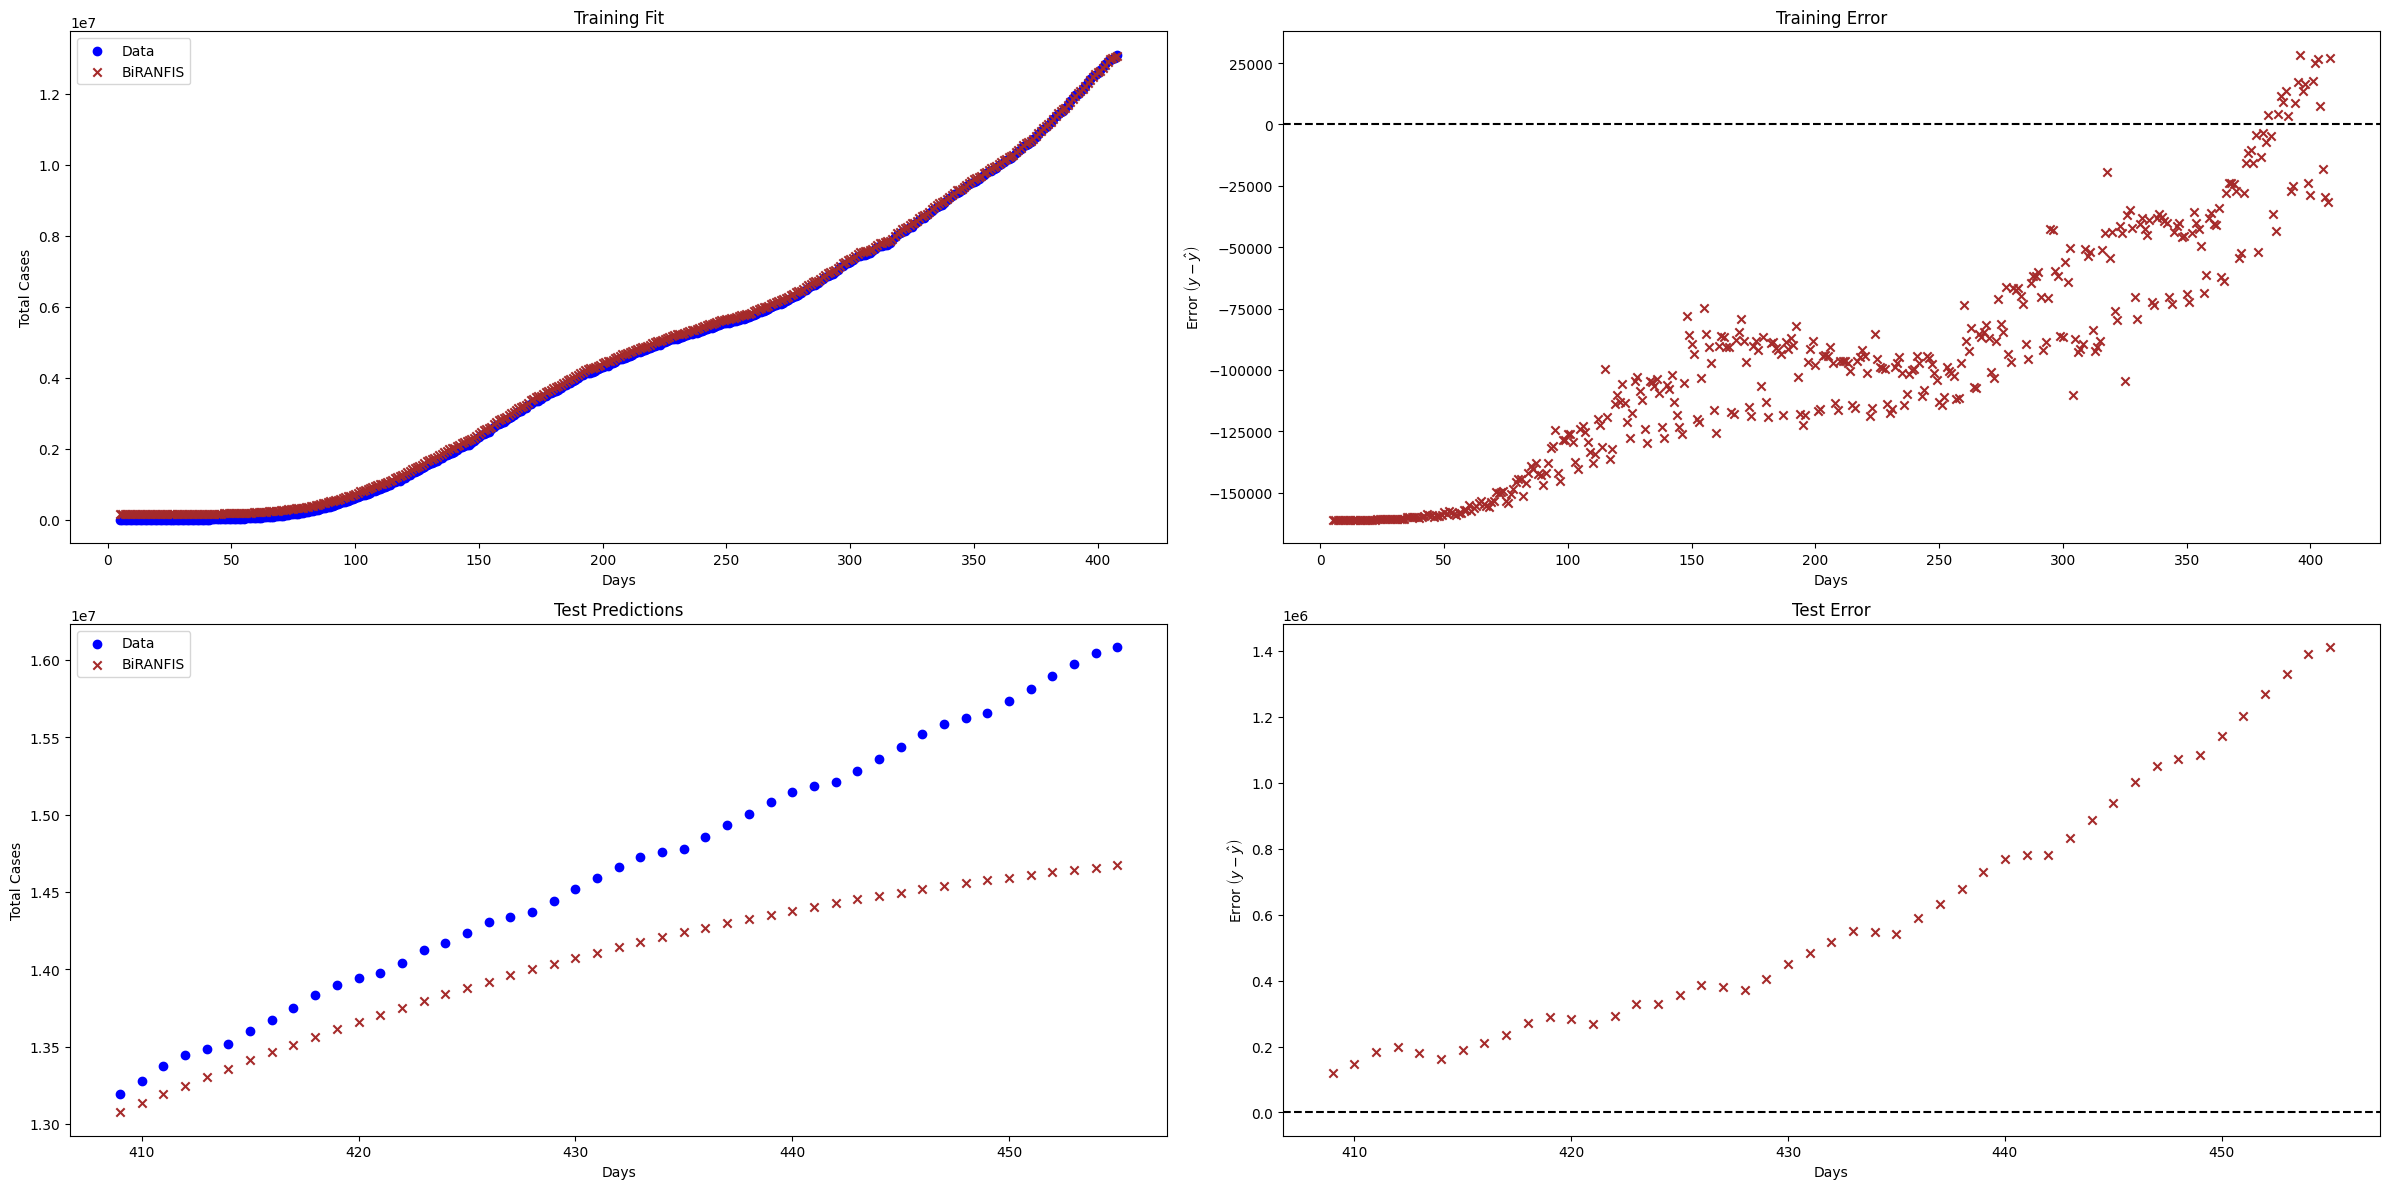

In [10]:
biranfis.eval()
test_predictions_biranfis = []

with torch.no_grad():
    train_predictions_biranfis = biranfis(x_train)[0][:, -1, :].numpy().flatten()
    
    last_data = x_train[-1:]
    h = None
    
    for _ in range(len(days_test)):  
        pred, hnew = biranfis(last_data, h)  
        test_predictions_biranfis.append(pred[:, -1:, :].item())
        last_data = torch.cat([last_data[:, 1:, :], pred[:, -1:, :]], dim=1)  
        h = hnew
        
train_predictions_biranfis = train_predictions_biranfis * (norm_max - norm_min) + norm_min
test_predictions_biranfis = np.array(test_predictions_biranfis) * (norm_max - norm_min) + norm_min

cases_train_denorm = cases_train[seq_len_biranfis:] * (norm_max - norm_min) + norm_min
cases_test_denorm = cases_test * (norm_max - norm_min) + norm_min

fig, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0, 0].scatter(aligned_days_train, cases_train_denorm, label='Data', c='blue')
ax[0, 0].scatter(aligned_days_train, train_predictions_biranfis, label='BiRANFIS', marker='x', c='brown')
ax[0, 0].set_title("Training Fit")
ax[0, 0].set_xlabel("Days")
ax[0, 0].set_ylabel("Total Cases")
ax[0, 0].legend()

ax[0, 1].scatter(aligned_days_train, cases_train_denorm - train_predictions_biranfis, color='brown', marker='x')
ax[0, 1].axhline(0, color='black', linestyle='--')
ax[0, 1].set_title("Training Error")
ax[0, 1].set_xlabel("Days")
ax[0, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

ax[1, 0].scatter(days_test, cases_test_denorm, label='Data', c='blue')
ax[1, 0].scatter(days_test, test_predictions_biranfis, label='BiRANFIS', marker='x', c='brown')
ax[1, 0].set_title("Test Predictions")
ax[1, 0].set_xlabel("Days")
ax[1, 0].set_ylabel("Total Cases")
ax[1, 0].legend()

ax[1, 1].scatter(days_test, cases_test_denorm - test_predictions_biranfis, color='brown', marker='x')
ax[1, 1].axhline(0, color='black', linestyle='--')
ax[1, 1].set_title("Test Error")
ax[1, 1].set_xlabel("Days")
ax[1, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

plt.tight_layout()
plt.show()

## Final Analysis

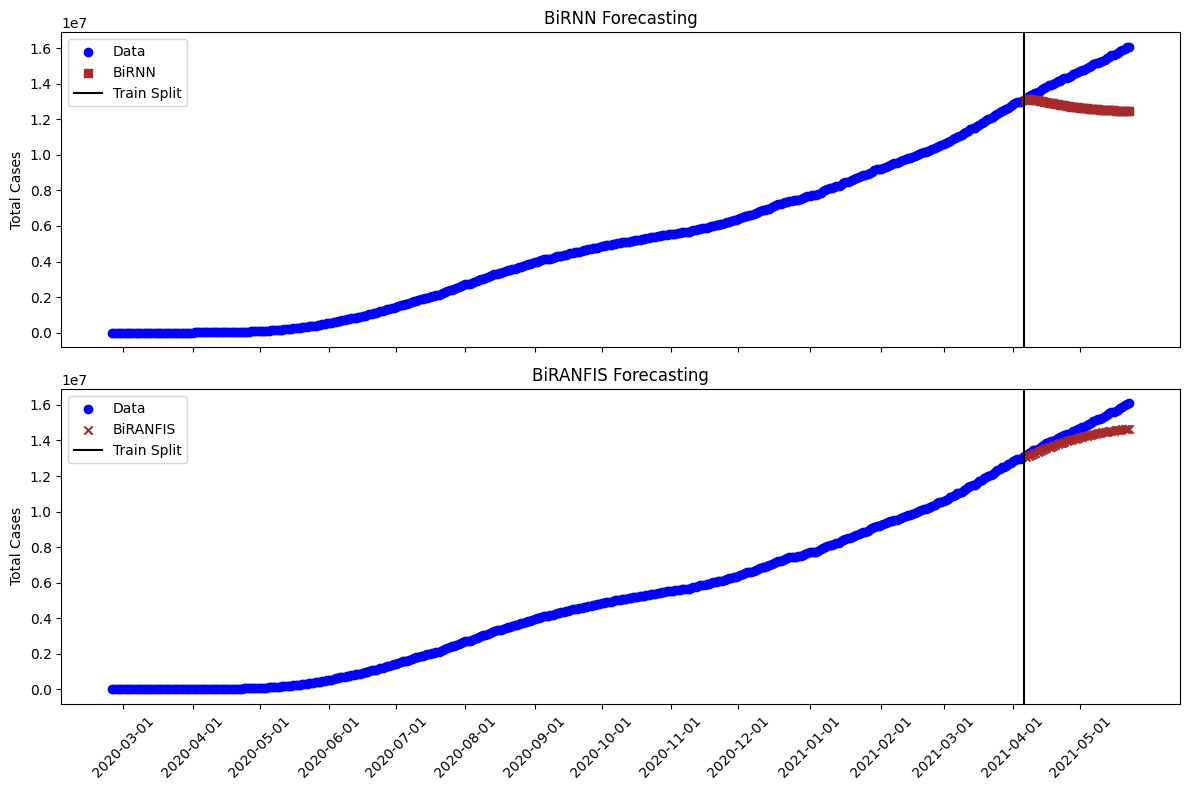

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax[0].scatter(days, cases, label='Data', color='blue')
ax[0].scatter(days_test, test_predictions_birnn, label='BiRNN', color='brown', marker='s')
ax[0].axvline(days_train.max(), linestyle='-', color='black', label='Train Split')
ax[0].set_xticks(ticks=tick_indices, labels=tick_labels, rotation=45)
ax[0].set_ylabel('Total Cases')
ax[0].set_title('BiRNN Forecasting')
ax[0].legend()

ax[1].scatter(days, cases, label='Data', color='blue')
ax[1].scatter(days_test, test_predictions_biranfis, label='BiRANFIS', color='brown', marker='x')
ax[1].axvline(days_train.max(), linestyle='-', color='black', label='Train Split')
ax[1].set_xticks(ticks=tick_indices, labels=tick_labels, rotation=45)
ax[1].set_ylabel('Total Cases')
ax[1].set_title('BiRANFIS Forecasting')
ax[1].legend()

plt.tight_layout()
plt.show()

In [12]:
rmse_birnn = np.sqrt(np.mean((cases_test_denorm - test_predictions_birnn)**2)).item()
rmse_biranfis = np.sqrt(np.mean((cases_test_denorm - test_predictions_biranfis)**2)).item()
mae_birnn = np.mean(np.abs(cases_test_denorm - test_predictions_birnn)).item()
mae_biranfis = np.mean(np.abs(cases_test_denorm - test_predictions_biranfis)).item()
mape_birnn = 100 * np.mean(np.abs((cases_test_denorm - test_predictions_birnn) / cases_test_denorm)).item()
mape_biranfis = 100 * np.mean(np.abs((cases_test_denorm - test_predictions_biranfis) / cases_test_denorm)).item()

print(f'BiRNN    | RMSE: {int(rmse_birnn)} | MAE: {int(mae_birnn)} | MAPE: {mape_birnn:.2f}% | Parameters: {params_birnn}')
print(f'BiRANFIS | RMSE: {int(rmse_biranfis)}  | MAE: {int(mae_biranfis)}  | MAPE: {mape_biranfis:.2f}%  | Parameters: {params_biranfis}')

BiRNN    | RMSE: 2190526 | MAE: 1925899 | MAPE: 12.78% | Parameters: 28675
BiRANFIS | RMSE: 708981  | MAE: 601040  | MAPE: 3.98%  | Parameters: 405
